# 0.0 IMPORTS

In [1]:
## 0.1 Helper Functions

import pandas as pd
import datetime
import inflection
import math
import numpy as np
import seaborn as sns
import xgboost as xgb
import random
import warnings
import pickle

from matplotlib            import pyplot as plt
from IPython.display       import Image
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy

## 0.1 Helper Functions

In [2]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( ( y - yhat ) / y ) )


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0,chi2 - ((k-1)*(r-1) / (n-1)) )
    
    kcorr = k - ((k-1)**2 / (n-1))
    rcorr = r - ((r-1)**2 / (n-1)) 
    
    return np.sqrt( (chi2corr/n) / (min(kcorr - 1, rcorr - 1) ) )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print( '\nKFold Number: {}'.format (k) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        #filtering dateset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop( ['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        #model
        m = model.fit( xtraining, ytraining )

        #prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        #store performance of each kforld iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round( np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round( np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round( np.std(rmse_list), 2).astype(str) }, index=[0] )

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
741565,876,4,2013-09-05,8516,1119,1,0,0,0,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"


# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill out NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                        else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                        else x['competition_open_since_year'], axis=1 )

                  
#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                        else x['promo2_since_week'], axis=1 )

#promo2_since_year     
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                        else x['promo2_since_year'], axis=1 )
                                                 


In [12]:
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }  

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )                          


In [13]:
df1.sample(5).T

,730622,748506,211779,717591,946748
store,1083,12,1045,317,899
day_of_week,7,4,5,4,2
date,2013-09-15 00:00:00,2013-08-29 00:00:00,2015-01-23 00:00:00,2013-09-26 00:00:00,2013-03-05 00:00:00
sales,0,8767,5886,4959,8340
customers,0,1007,705,499,843
open,0,1,1,1,1
promo,0,1,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,a,d,d


## 1.6 Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

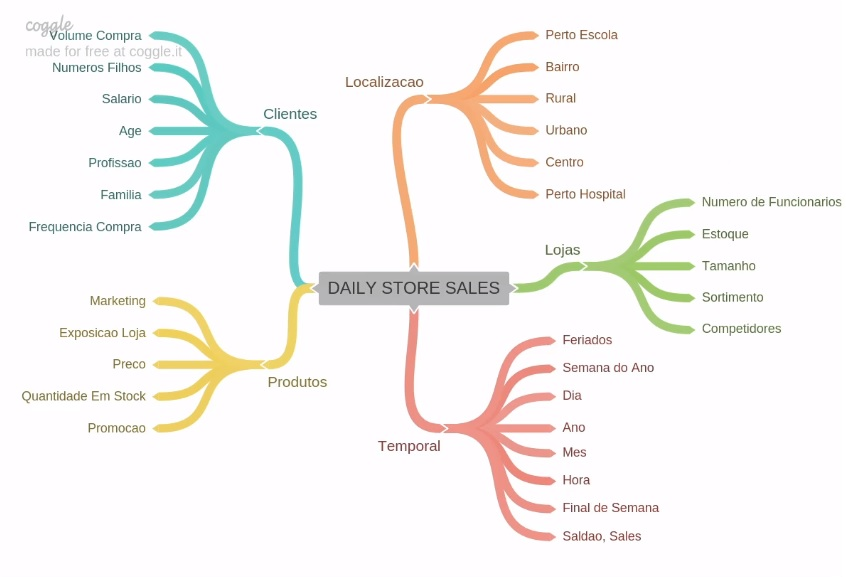

In [18]:
Image('img\MindMapHypothesis.jpg')

## 2.1 Criação de Hipóteses

### 2.1.1 Hipoteses Loja

In [19]:
**1.** Lojas com maior quadro de funcionario deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com menor porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

SyntaxError: invalid syntax (<ipython-input-19-135e2000e1ab>, line 1)

### 2.1.2 Hipoteses Produto

In [ ]:
**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposicao de produtos deveriam vender mais.

**3.** Lojas com produtos com preco menor deveriam vender mais

**4.** Lojas com promocoes mais agressivas (maiores descontos) deveriam vender mais

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promocao deveriam vender mais

**7.** Lojas com mais promocoes consecutivas deveriam vender mais

### 2.1.3 Hipoteses Tempo

In [ ]:
**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas  deveriam vender mais depois do dia 10 de cada meses

**5.** Lojas  deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista Final de Hipoteses 

In [ ]:
**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

In [ ]:
**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promocao deveriam vender mais

**6.** Lojas com mais promocoes consecutivas deveriam vender mais

In [ ]:
**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas  deveriam vender mais depois do dia 10 de cada meses

**11.** Lojas  deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days).astype( 'int64' )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype( 'int64' )


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


<ipython-input-20-cf3664a5a4f2>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [24]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [25]:
cols_drop = ['open', 'customers', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1)

In [26]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [27]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

C:\Users\iCone\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

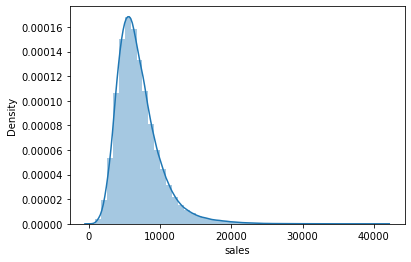

In [28]:
sns.distplot(df4['sales'])

### 4.1.2 Numberical Variable

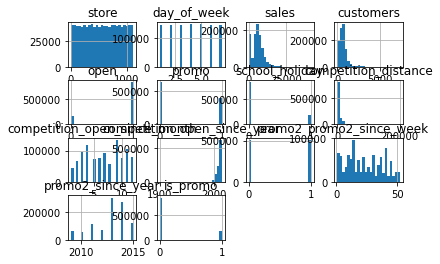

In [29]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [30]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

C:\Users\iCone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\iCone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\iCone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

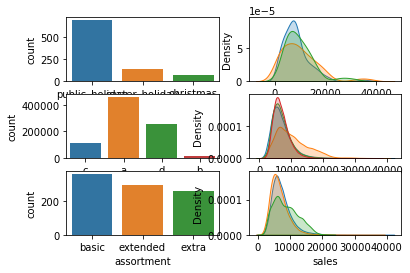

In [31]:
# State Holiday

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='public_holiday', shade=True, )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='public_holiday', shade=True, )


# Store Type

plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True, )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, )

# Assortment

plt.subplot( 3, 2, 5)
sns.countplot( a['assortment'] )

plt.subplot( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True, )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True, )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, )



## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

<AxesSubplot:xlabel='year_week'>

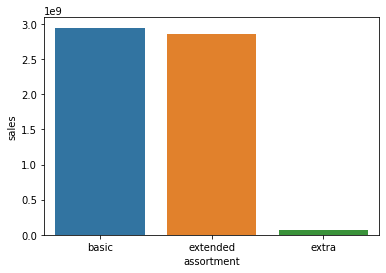

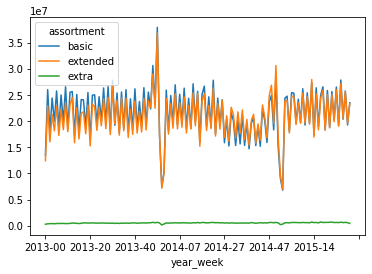

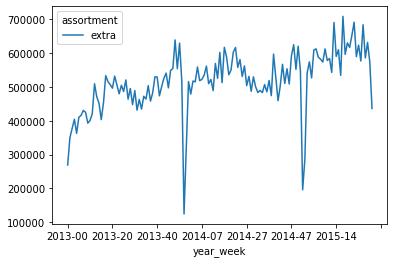

In [32]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### **H2.** Lojas com competidores mais proximos deveriam vender menos
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MENOS.

<AxesSubplot:>

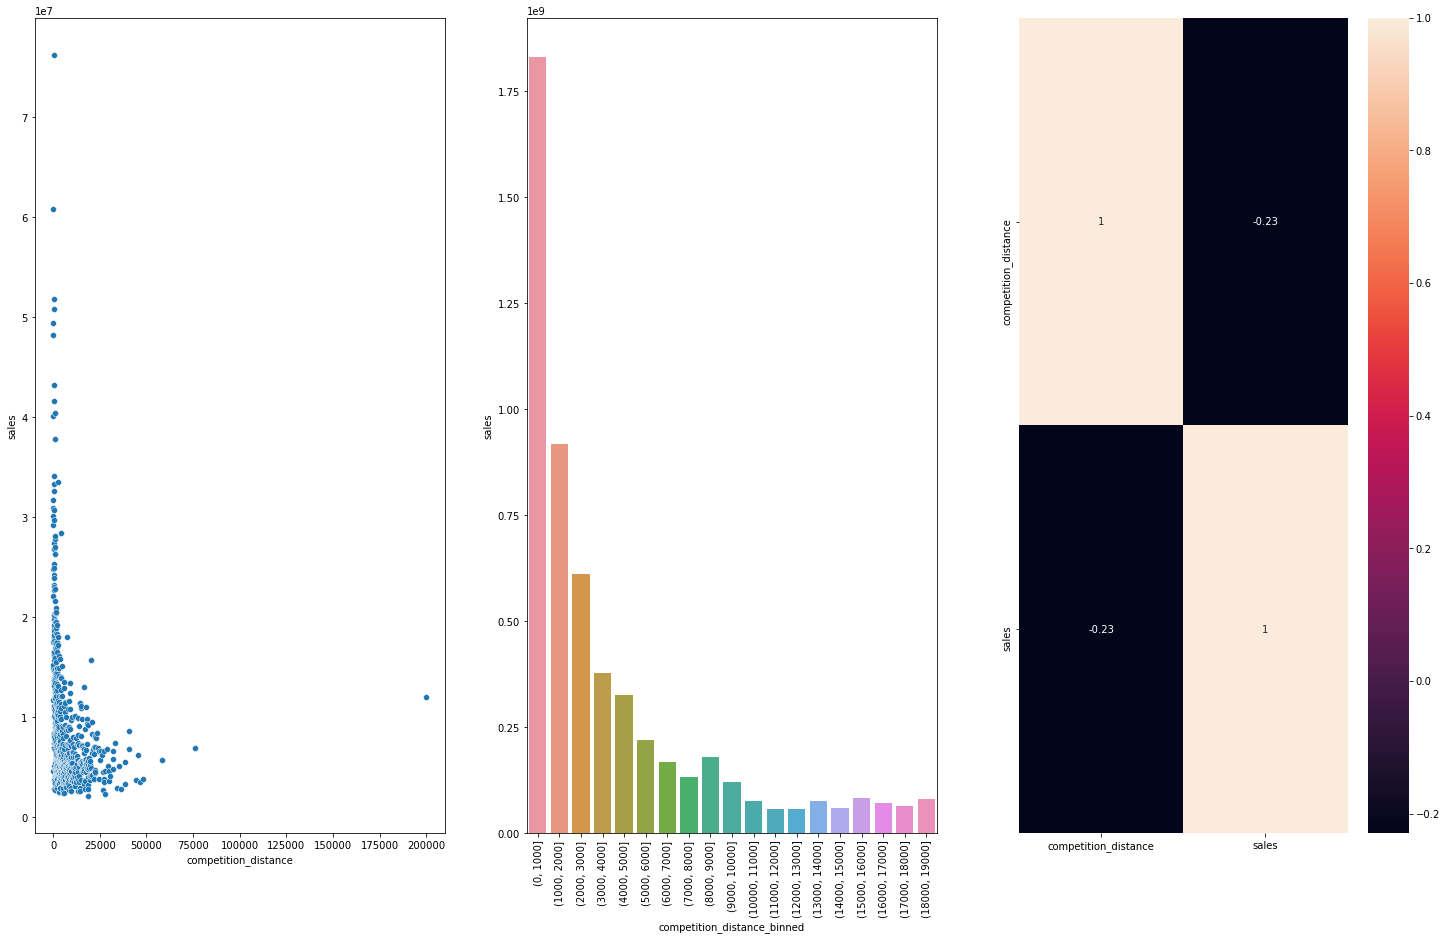

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure( figsize=(25,15))

plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)


### **H3.** Lojas com competidores a mais tempo deveriam vender mais
**FALSA** Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.

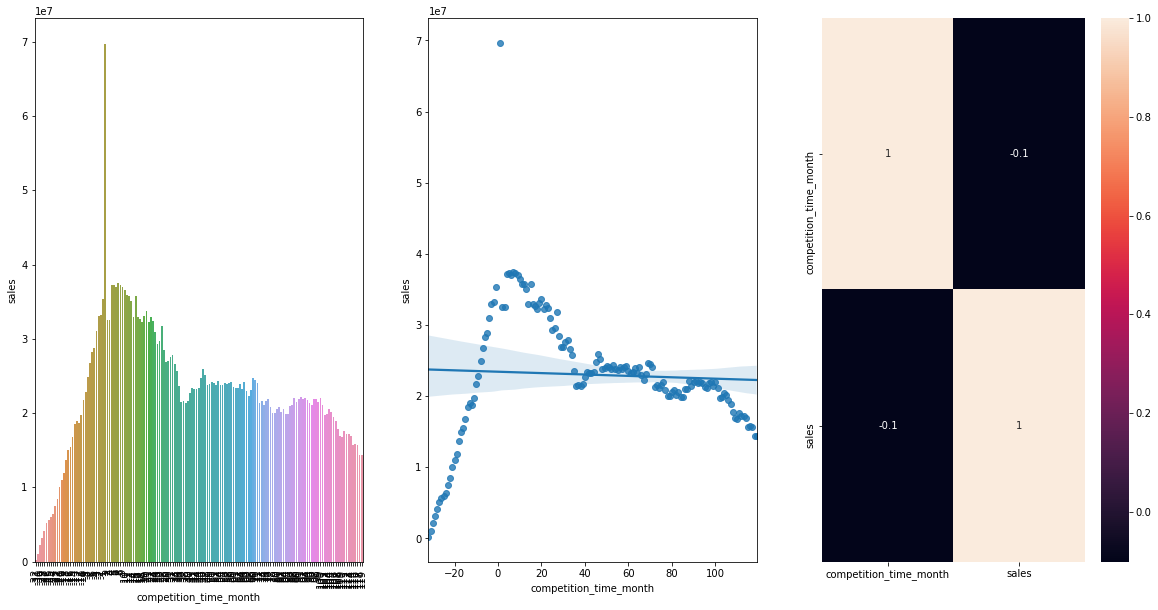

In [34]:
plt.figure( figsize=(20, 10))

plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos depois de um certo periodo de promocao

<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

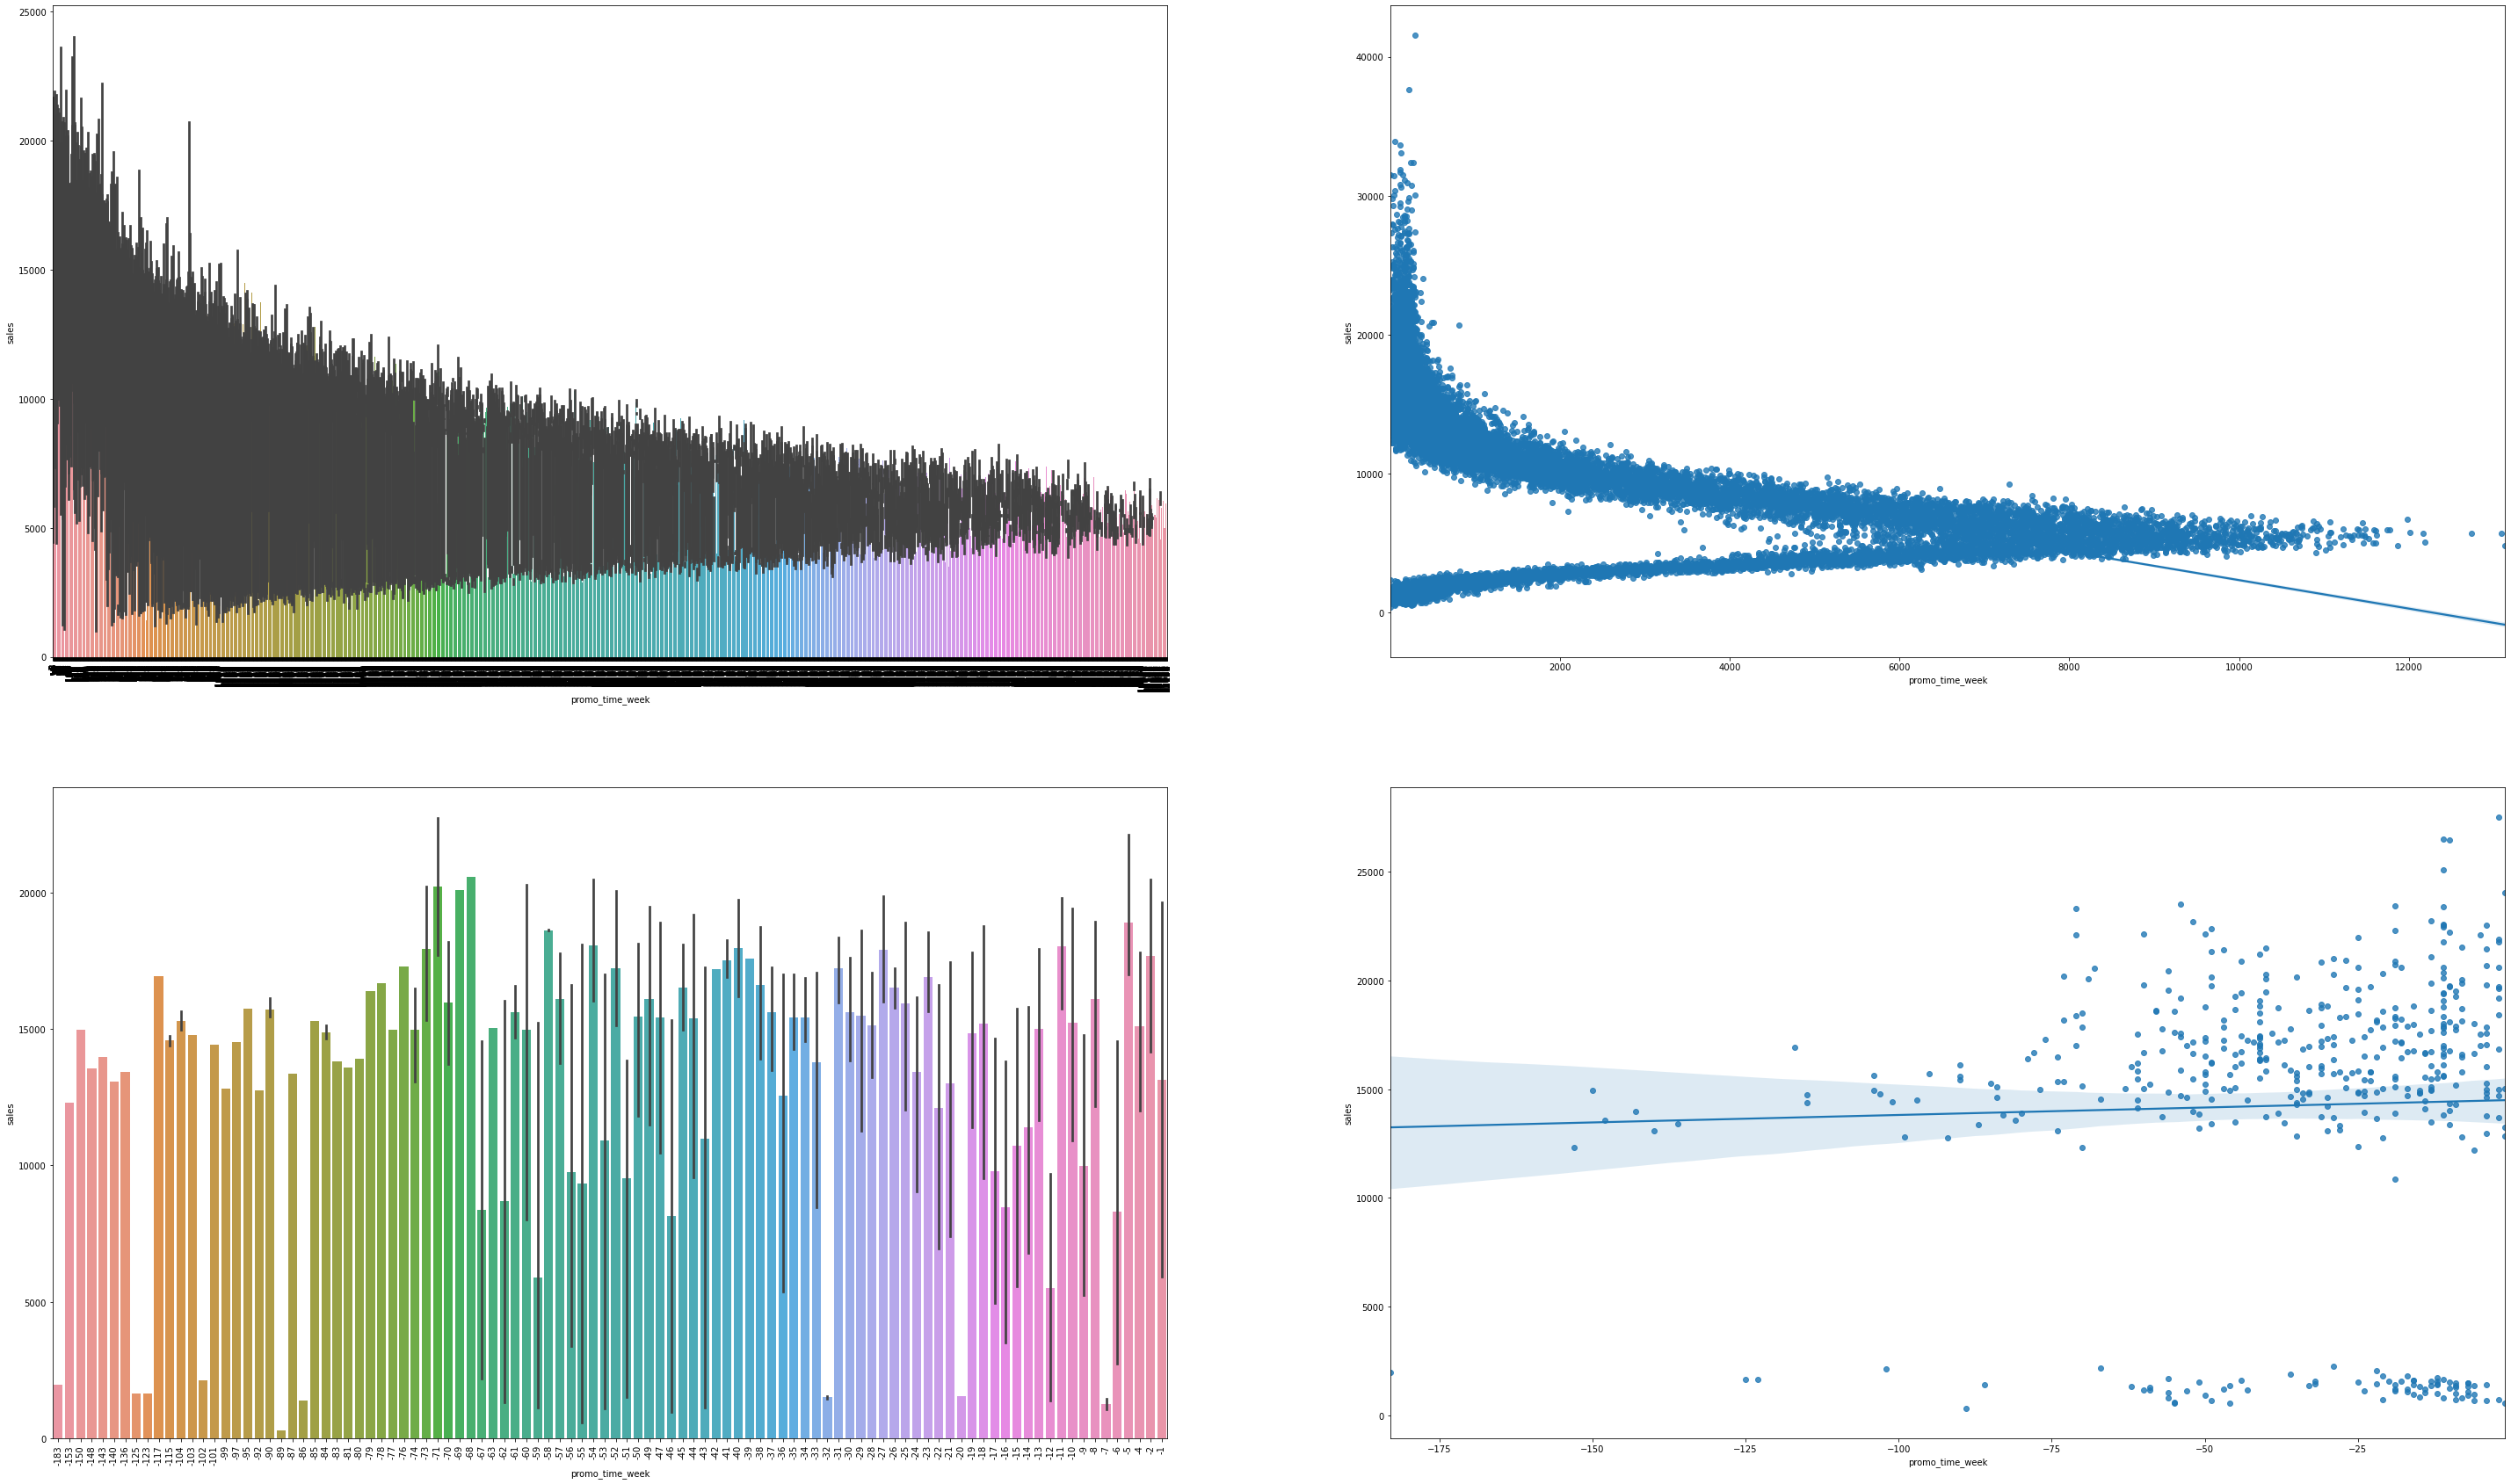

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby('sales').sum().reset_index()

plt.figure(figsize=(50,30))

plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(2, 2, 2)
sns.regplot( x='promo_time_week', y='sales', data=aux2)


plt.subplot(2, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(2, 2, 4)
sns.regplot( x='promo_time_week', y='sales', data=aux3)












### <s>**H5.** Lojas com mais dias de promocao deveriam vender mais</s>

### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais
**FALSA** Lojas com promocoes consecutivas vendem menos

In [36]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


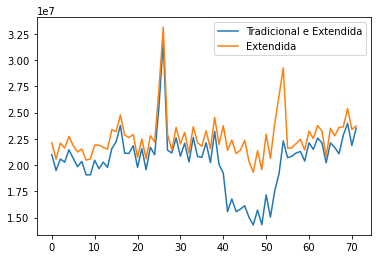

In [37]:


aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()



aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )


ax.legend(labels=['Tradicional e Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem menos

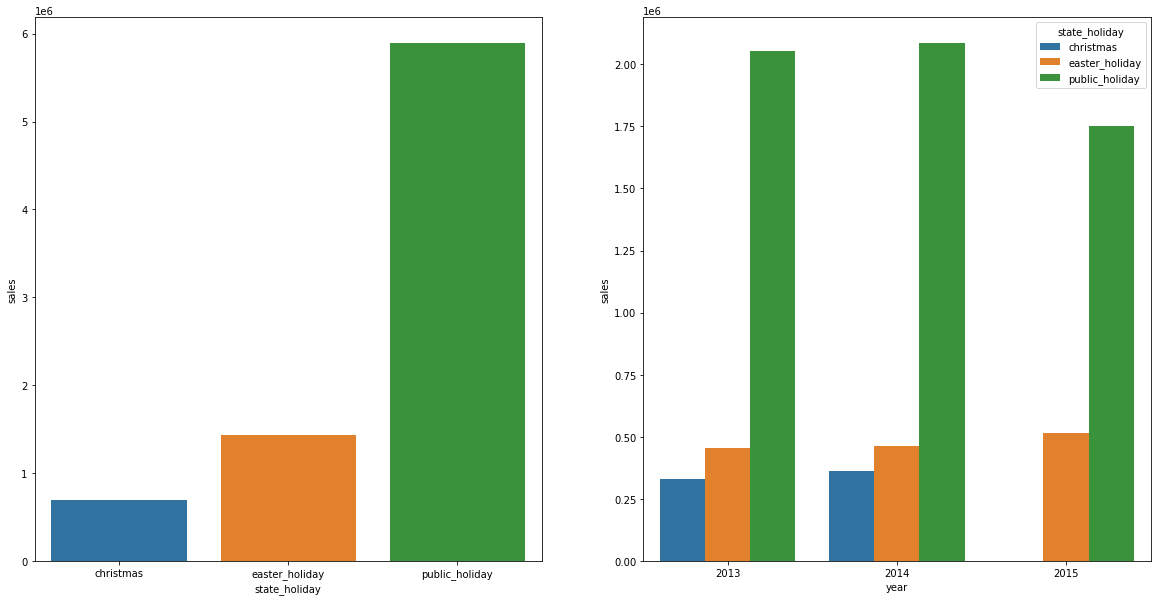

In [38]:
plt.figure( figsize=( 20, 10))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot (1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);


###  **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

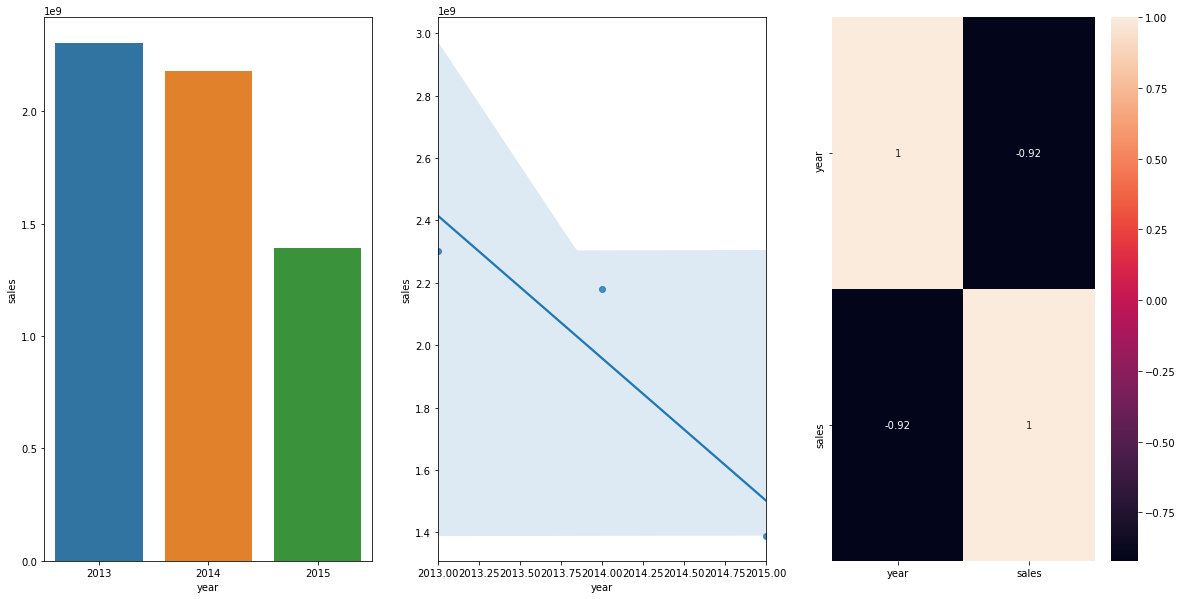

In [39]:
plt.figure( figsize=(20, 10))

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


###  **H9.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

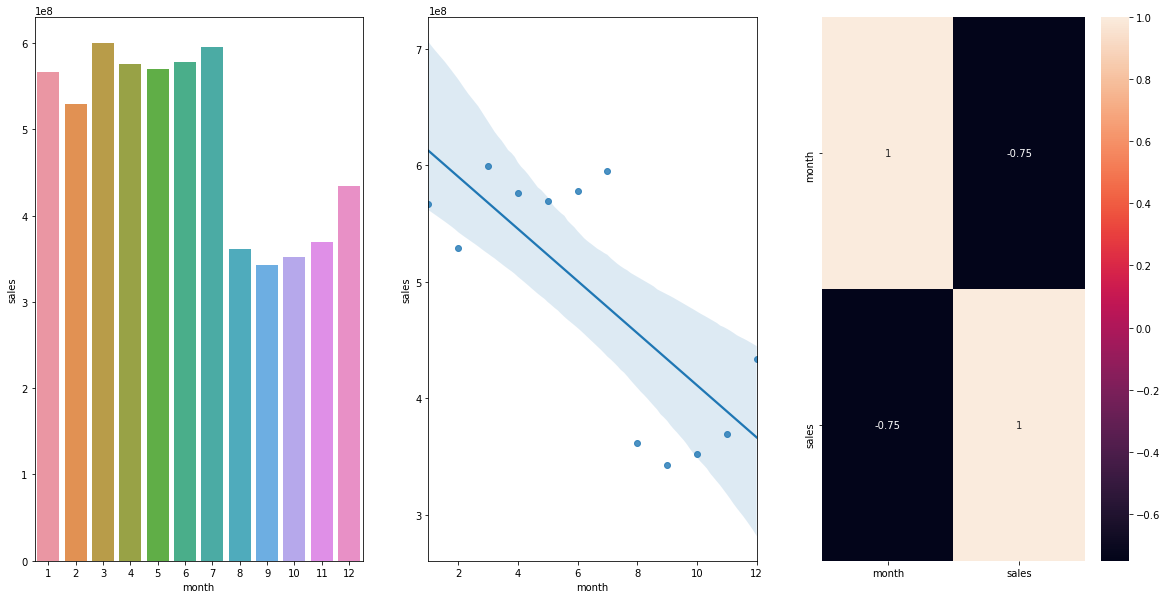

In [40]:
plt.figure( figsize=(20, 10))

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


###  **H10.** Lojas  deveriam vender mais depois do dia 10 de cada meses
**TRUE** Lojas vendem mais depois do dia 10 de cada mes

<AxesSubplot:xlabel='before_after', ylabel='sales'>

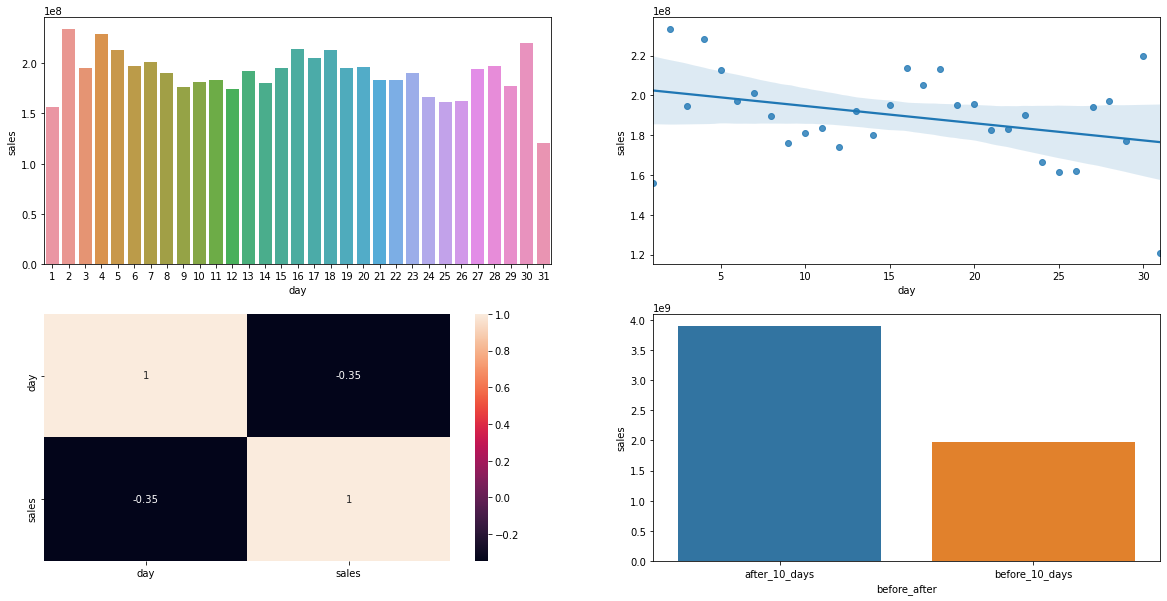

In [41]:
plt.figure( figsize=(20, 10))

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot( 2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

### **H11.** Lojas  deveriam vender menos aos finais de semana
**TRUE** Lojas vendem menos aos finais de semana

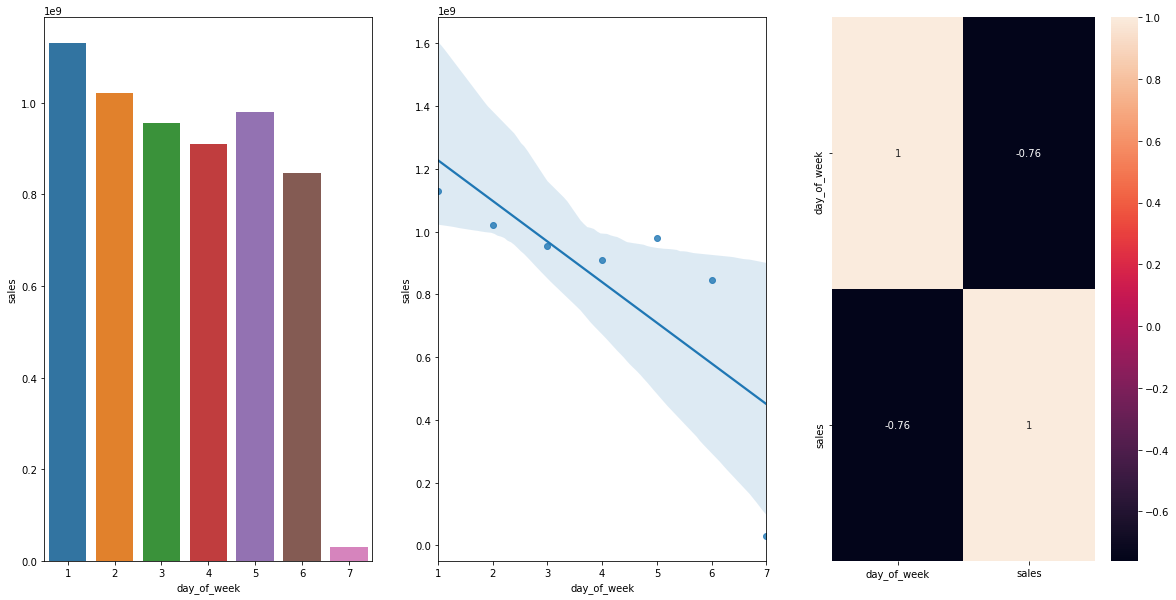

In [42]:
plt.figure( figsize=(20, 10))

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIR** Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

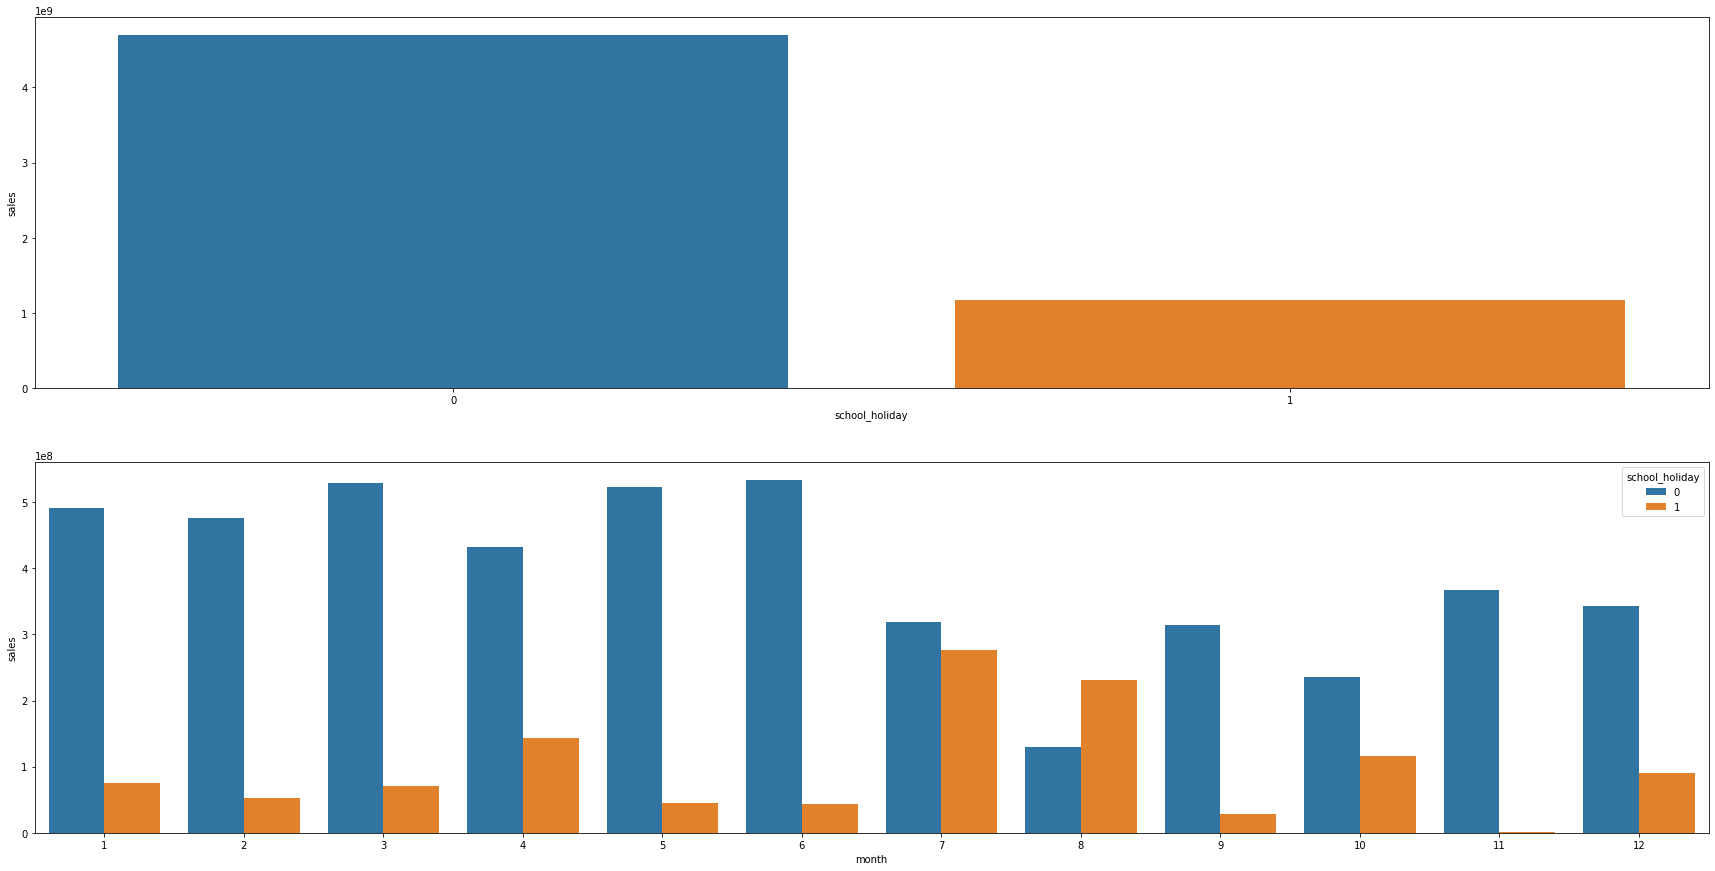

In [43]:
plt.figure( figsize=( 30, 15))

plt.subplot( 2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

## 4.3 Análise Multivariada

## 4.3.1 Numerical Attributes

<AxesSubplot:>

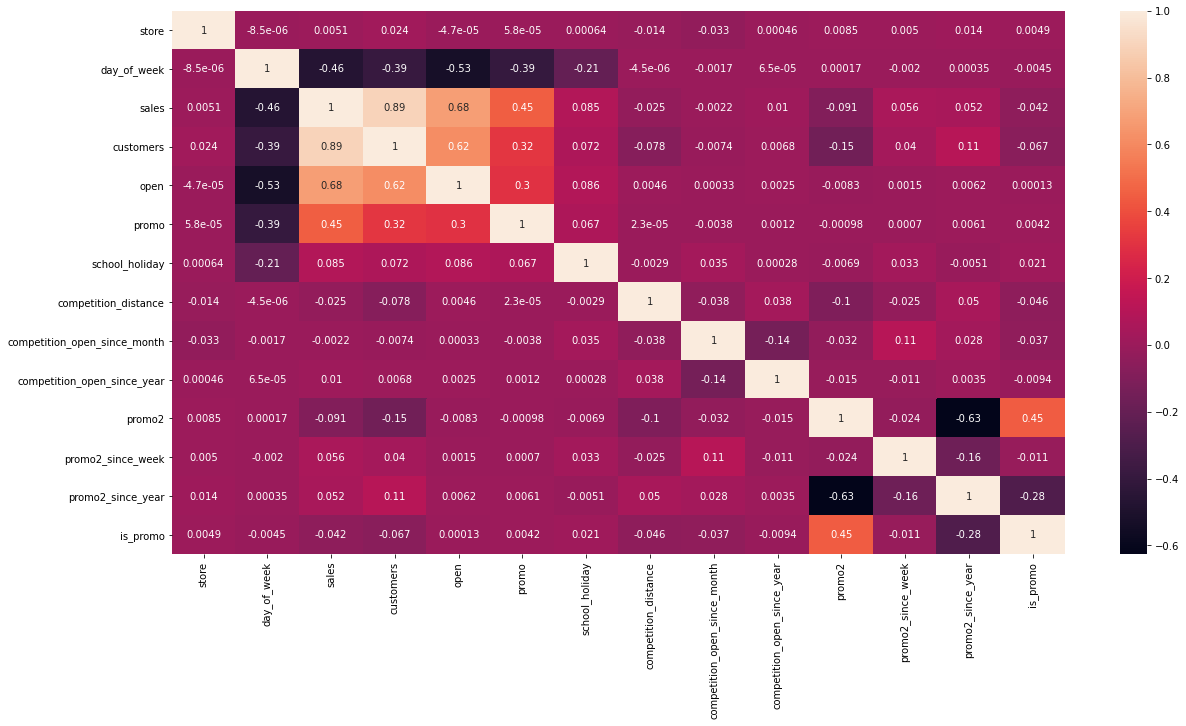

In [44]:
plt.figure( figsize=(20,10) )

correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True)

## 4.3.2 Categorial Attributes

<AxesSubplot:>

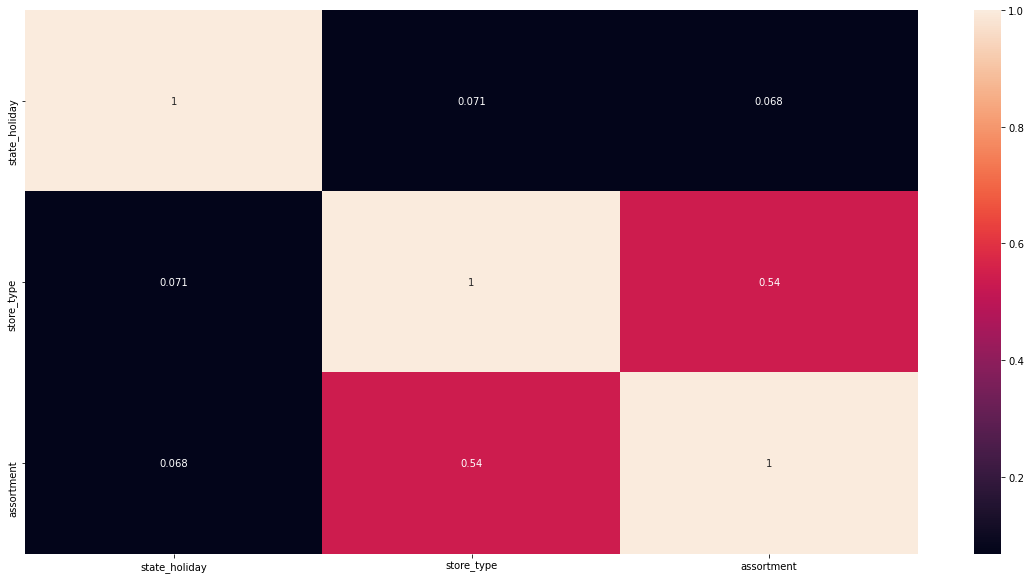

In [45]:
# Only categorical data

a = df4.select_dtypes( include= 'object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

# Heatmap
plt.figure( figsize=(20, 10))

sns.heatmap( d, annot=True)

# 5.0 PASSO 05 - DATA PREPARATION

In [46]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.2 Rescaling

In [47]:
a = df5.select_dtypes( include=['float64', 'int64'])

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb'))


# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))


# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Enconding

In [49]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [50]:
# state_holiday - One hot enconding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb'))

### 5.3.2 Response Variable Transformation

In [51]:
df5['sales'] = np.log1p( df5['sales'])

C:\Users\iCone\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

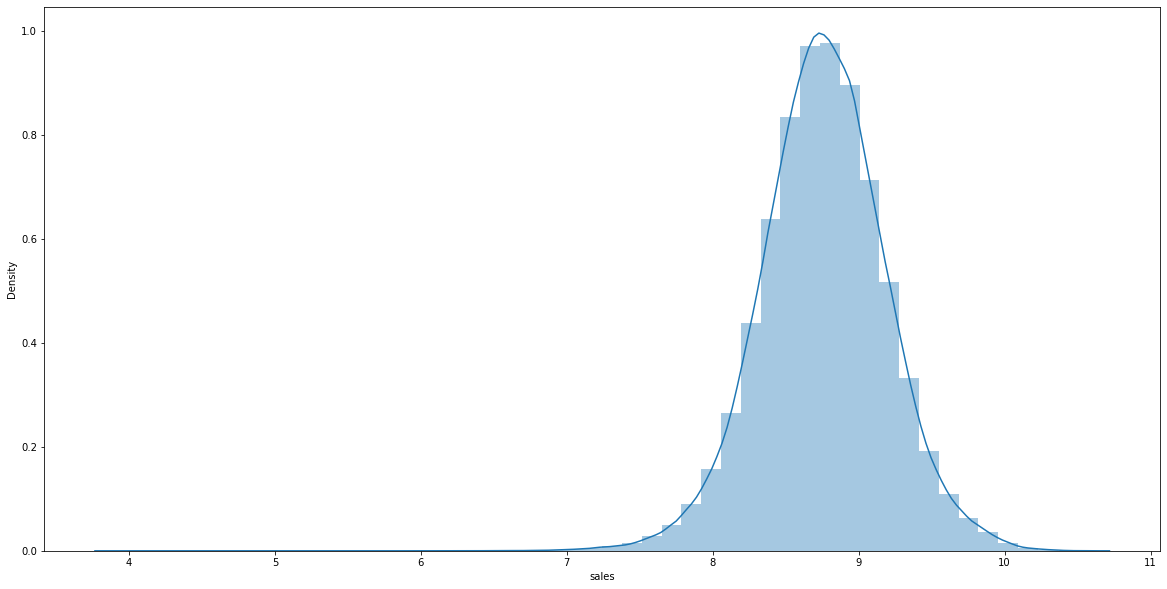

In [52]:
plt.figure(figsize=(20,10))
sns.distplot( df5['sales'] )

### 5.3.3 Nature Transformation

In [53]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

# 6.0 PASSO 06 - FEATURE SELECTION

In [54]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [55]:
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop( cols_drop, axis=1)

In [56]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 7*6)

Timestamp('2015-06-19 00:00:00')

In [57]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [58]:
# Training and Test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1 ).values
y_train_n = y_train.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1)

# Define boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best features from boruta

In [59]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta 
cols_not_selected_boruta = list( np.setdiff1d(X_train_fs.columns, cols_selected_boruta) )

## 6.3 Manual Feature Selection

In [60]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'week_of_year_sin',
     'week_of_year_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final feature
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [61]:
x_train = X_train[ cols_selected_boruta ]
x_test  = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 - Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['sales', 'store']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [63]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 - Linear Regression Model - Cross Validation

In [64]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [65]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451738


### 7.3.1 Lasso - Cross Validation

In [66]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [67]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.891469,0.099859,1009.419036


### 7.4.1 Random Forest Regressor - Cross Validation

In [68]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97 +/- 219.05,0.12 +/- 0.02,1257.65 +/- 320.89


## 7.5 XGBoost Regressor

In [69]:
# model
model_xgb = xgb.XGBRegressor().fit( x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


### 7.5.1 XGBoost Regressor - Cross Validation

In [70]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1070.32 +/- 183.4,0.15 +/- 0.02,1529.25 +/- 251.22


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [71]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.891469,0.099859,1009.419036
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451738


### 7.6.2 Real Performance - Cross Validation

In [72]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.97 +/- 219.05,0.12 +/- 0.02,1257.65 +/- 320.89
0,XGBoost Regressor,1070.32 +/- 183.4,0.15 +/- 0.02,1529.25 +/- 251.22


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

In [73]:
warnings.filterwarnings( 'ignore' )

In [74]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [75]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = {k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result])
    
final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}


KeyboardInterrupt: 

## 8.2 Final Model

In [76]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}


In [77]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance    
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,766.091894,0.114904,1098.919714


# 9.0 PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [78]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [79]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [80]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
21,22,175230.750000,174787.481439,175674.018561,443.268561,0.091616
1007,1008,200588.421875,200153.888025,201022.955725,434.533850,0.075634
209,210,121363.382812,121041.607415,121685.158210,321.775397,0.107242
470,471,260837.984375,260259.565258,261416.403492,578.419117,0.080887


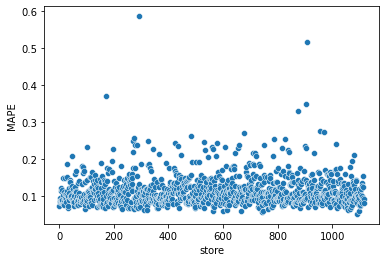

In [81]:
sns.scatterplot( x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [82]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum( x ), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,852,288.00"
1,worst_scenario,"R$284,995,117.11"
2,best_scenario,"R$286,709,499.00"


## 9.3 Machine Learning Performance

In [83]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

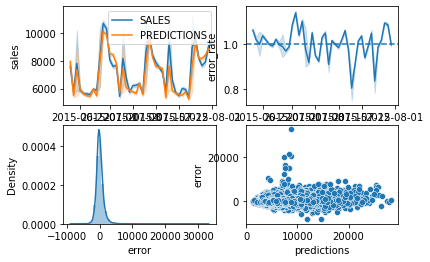

In [84]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot( df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error']);

# 10.0 PASSO 10 - Deploy Model to Production

In [85]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/iCone/Repos/DataScience_Em_Producao/model/model_rossman.pkl', 'wb'))

## 10.1 - Rossman Class

In [88]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossman( object ):
    def __init__( self ):
        
        self.home_path='/Users/iCone/Repos/DataScience_Em_Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open( self.home_path +  'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load( open( self.home_path +  'parameter/store_type_scaler.pkl', 'rb'))
        
        
        
    def data_cleaning( self, df1 ):
        

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fill out NA
        df1['competition_distance'].max()

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1 )


        #promo2_since_week  
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                else x['promo2_since_week'], axis=1 )

        #promo2_since_year     
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                else x['promo2_since_year'], axis=1 )



        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }  

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )                          

        ## 1.6 Change Types

        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

        return df1

    
    def feature_engineering( self, df2):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days).astype( 'int64' )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype( 'int64' )

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1 Filtragem das linhas

        df2 = df2[(df2['open'] != 0)]

        ## 3.2 Seleção das colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1)
        
        return df2

        
        
    def data_preparation( self, df5 ):
        
        ## 5.2 Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition_time_month
        df5['competition_time_month'] = self_competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo_time_week
        df5['promo_time_week'] = self_promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        # year
        df5['year'] = self_year_scaler.fit_transform( df5[['year']].values )
        
        
        ### 5.3.1 Enconding
        # state_holiday - One hot enconding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,
                           'extra': 2,
                           'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        ### 5.3.3 Nature Transformation

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )
        
        cols_selected = [ 'store','promo', 'store_type','assortment','competition_distance',
                                'competition_open_since_month','competition_open_since_year','promo2','promo2_since_week',
                                'promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                                'week_of_year_sin','week_of_year_cos','month_sin','month_cos','day_sin','day_cos']
        
        
        return df5[ cols_selected ]
    
    

    def get_prediction( self, model, original_data, test_data):
        # prediction
        pred = model.prediction( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 - API Handler

In [92]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossman.Rossman import Rossman

# loading model
model = pickle.load( open( '/Users/iCone/Repos/DataScience_Em_Producao/model/model_rossman.pkl', 'rb' ))

# initialize API
app = Flask(__name__)

@app.route('/rossman/predict', methods=['POST'])
def rossman_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        
        
        else: # multiple example   
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )
            
            
        # instantiate Rossman class
        pipeline = Rossman()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # predict
        df_response = pipeline.get_prediction( model, test_raw, df3)
        
        return df_response
                
    else:
        return Reponse('{}', status=200, mimetype='application/json')
    
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


## 10.3 - API Tester

In [99]:
import requests

In [100]:
# loading test dataset
df10 = pd.read_csv('data/test.csv')

In [101]:
df10.head().columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [102]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'] == 22] 

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [1]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict( orient='records') )

NameError: name 'df_test' is not defined

In [104]:
# API Call
url = 'http://0.0.0.0:5000/rossman/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header)
print('Status Code {}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /rossman/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000019A38707AC0>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))